<div class="alert alert-block alert-info">

## <center> GROUP PROJECT - TO GRANT OR NOT TO GRANT: DECIDING ON COMPENSATION BENEFITS </center> <br>
#  <center> <b> XGBOOST </center> <br>
## <center> Fall Semester 2024-2025 <center>
<br>
<center> Group 46: <center> <br>
<center>Afonso Ascensão, 20240684 <br><center>
<center>Duarte Marques, 20240522 <br><center>
<center>Joana Esteves, 20240746 <br><center>
<center>Rita Serra, 20240515 <br><center>
<center>Rodrigo Luís, 20240742 <br><center>

<div>

**Description of contents:**
- Apply pipeline to preprocess the data.
- Implement xgboost algorithm, perform tuning of hyperparameters making use of gridsearch.
- Assessement of the model using cross validation.
- Generate predictions for the test sample.
- Optimize the model: adjusting encoding, feature selection strategy and applying resampling strategy with SMOTE.

**Table of Contents**
- [1. Import the needed Libraries](#importlibraries)
- [2. Import Dataset](#importdataset)
- [3. Preprocessing](#section_3)
- [4. XGBoost](#section_4)
- [5. Optimization](#section_5)


<a class="anchor" id="section_1">

# 1. Import Libraries

</a>

In [1]:

import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Preprocessing
## Pipeline
from sklearn.pipeline import Pipeline
from joblib import load
from transformers import *
from sklearn.base import BaseEstimator, TransformerMixin
## Target Encoding
from sklearn.preprocessing import LabelEncoder

# Model algorithm - xgboost
from xgboost import XGBClassifier
## Weights 
from sklearn.utils.class_weight import compute_sample_weight

# Resampling
from imblearn.over_sampling import SMOTE

from scipy.stats import chi2_contingency, levene

# Evaluation metrics
from sklearn.metrics import classification_report, make_scorer, f1_score

# Cross validation, parameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score
from itertools import product

np.random.seed(42)

# Define a seed
random_state = 42

# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)

<a class="anchor" id="section_2">

# 2. Import Dataset and Pipeline

</a>

In [2]:
# Train and validation w/ split, separate X and y to apply preprocessing
transformed_train_split = pd.read_parquet("transformed_train_split.parquet")
transformed_val_split = pd.read_parquet("transformed_val_split.parquet")

# Test set with predicted agreement column, apply preprocessing 
test_transformed_agreement = pd.read_parquet("test_transformed_agreement.parquet")

# Dataset with no split for cross validation, apply pipeline inside cross validation
transformed_train_data = pd.read_parquet("transformed_train_data.parquet")

In [3]:
# Load pipeline
pipeline = load('pipeline.joblib') 

<a class="anchor" id="section_3">

# 3. Preprocessing

</a>

In [4]:
# Separate X and y for train after split
X_train = transformed_train_split.drop(['Claim Injury Type'], axis = 1)
y_train = transformed_train_split['Claim Injury Type']
y_train = y_train.values.ravel()

# Separate X and y for validation after split
X_val = transformed_val_split.drop(['Claim Injury Type'], axis = 1)
y_val = transformed_val_split['Claim Injury Type']

# Separate X and y for dataset before split
X = transformed_train_data.drop(['Claim Injury Type'], axis = 1)
y = transformed_train_data['Claim Injury Type']

In [5]:
# Apply encoding of y for train and validation sets

# Initialize target encoder
label_encoder = LabelEncoder()

# Encode target
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [6]:
# Apply preprocessing pipeline to the train, validation and test sets
X_train_preprocessed = pipeline.fit_transform(X_train, y_train_encoded)
X_val_preprocessed = pipeline.transform(X_val)
test_data_preprocessed = pipeline.transform(test_transformed_agreement)

In [7]:
print("Selected Features:", X_train_preprocessed.columns.values)

Selected Features: ['Attorney/Representative' 'Average Weekly Wage Log' 'C-2 Delivered'
 'Industry Code' 'Time Assembly to Hearing' 'Hearing Held'
 'Agreement Reached' 'C-3 Delivered on Time' 'Part of Body Group_Trunk'
 'Part of Body Group_Lower Extremities' 'IME-4 Count Log'
 'District Name_NYC' 'Part of Body Group_Upper Extremities' 'Gender'
 'Carrier Type_2A. SIF' 'Cause of Injury Group_X' 'Assembly Year'
 'Cause of Injury Group_VI']


<a class="anchor" id="section_4">

# 4. XGBoost

</a>

**Variables for model:**
- X_train_preprocessed;
- y_train_preprocessed;
- X_val_preprocessed;
- y_val_encoded;
- test_data_preprocessed.

**Variables for CV:**
- X: no preprocessing and no split;
- y: no preprocessing and no split;
- Apply pipeline and weights inside cv.


**Hyperparameter tuning:**

In [9]:
''' # Perform custom grid search

# Initialize model
model_xgb = XGBClassifier(objective='multi:softmax', random_state=random_state)

# Define parameter grid
param_grid = {
    'n_estimators': [80, 120, 150],
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.4, 0.7, 0.9]
}

# Generate all parameter combinations
param_grid_list = [
    dict(zip(param_grid.keys(), values))
    for values in product(*param_grid.values())
]

# Cross-validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Initialize target encoder
label_encoder = LabelEncoder()

scores = []
best_params = []

for params in param_grid_list:
    fold_scores = []
    for train_idx, val_idx in kf.split(X, y):
        
        # Split the data for the current fold
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        # Encode target
        y_train_cv_encoded = label_encoder.fit_transform(y_train_cv)
        y_val_cv_encoded = label_encoder.transform(y_val_cv)
    
        # Preprocess training and validation sets
        X_train_cv_preprocessed = pipeline.fit_transform(X_train_cv, y_train_cv_encoded)
        X_val_cv_preprocessed = pipeline.transform(X_val_cv)
    
        # Compute sample weights for the training data
        train_sample_weights = compute_sample_weight('balanced', y_train_cv_encoded)
    
        # Initialize model with parameters
        model_xgb.set_params(**params)

        # Fit model using sample weights
        model_xgb.fit(X_train_cv_preprocessed, y_train_cv_encoded, sample_weight=train_sample_weights)
        
        # Predict and evaluate
        y_pred_cv = model_xgb.predict(X_val_cv_preprocessed)
        f1 = f1_score(y_val_cv_encoded, y_pred_cv, average='macro')

        fold_scores.append(f1)

    # Average score for this parameter set
    avg_score = np.mean(fold_scores)
    scores.append(avg_score)
    best_params.append(params)

# Get the final best parameters and score
best_index = np.argmax(scores)
print("Best parameters:", best_params[best_index])
# Final assessment score for the selected parameter set
print("Best score:", scores[best_index]) '''


Best parameters: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.2, 'subsample': 0.7}
Best score: 0.42115294710189344


- Best parameters: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.2, 'subsample': 0.7}
- Best f1 macro score: 0.42115294710189344

In [12]:
''' # Model with grid search best parameters
# Compute weights for each sample
weights = compute_sample_weight('balanced', y_train_encoded)

model_xgbc_gs = XGBClassifier(
                           objective='multi:softmax',
                           n_estimators = 150,
                           max_depth = 10,
                           learning_rate = 0.2,
                           subsample = 0.7,
                           random_state = random_state
                           )

# Fit to train data
model_xgbc_gs.fit(X_train_preprocessed, y_train_encoded, sample_weight=weights)

y_pred_train = model_xgbc_gs.predict(X_train_preprocessed)
# Make predictions on validation data
y_pred_val = model_xgbc_gs.predict(X_val_preprocessed)

print("\nClassification Report Train Data:\n", classification_report(y_train_encoded, y_pred_train, digits=6))
print("\nClassification Report Validation Data:\n", classification_report(y_val_encoded, y_pred_val, digits=6)) '''


Classification Report Train Data:
               precision    recall  f1-score   support

           0   0.290255  0.846647  0.432303     11229
           1   0.896576  0.829370  0.861665    261970
           2   0.445020  0.400687  0.421691     62016
           3   0.898781  0.775244  0.832454    133656
           4   0.659387  0.908911  0.764299     43452
           5   0.390400  1.000000  0.561565      3790
           6   0.977528  1.000000  0.988636        87
           7   0.586685  1.000000  0.739510       423

    accuracy                       0.772393    516623
   macro avg   0.643079  0.845107  0.700265    516623
weighted avg   0.805860  0.772393  0.781491    516623


Classification Report Validation Data:
               precision    recall  f1-score   support

           0   0.244222  0.702724  0.362472      1248
           1   0.884784  0.819431  0.850854     29108
           2   0.308253  0.269956  0.287837      6890
           3   0.816217  0.709649  0.759212     14851
 

- The results show the your model is overfitting, as the performance on the training data (f1 macro 0.7) is significantly better than on the validation data (f1 macro 0.42).
- The model is not predicting class 6.
- We will reduce learning rate to try to capture more complex patterns and predict class 6, this can also help with overfitting.
- We will remove the parameter subsample = 0.7, because we have very few observations for class 6 and 7.

In [8]:
# Compute weights for each sample
weights = compute_sample_weight('balanced', y_train_encoded)

model_xgbc_tuned = XGBClassifier(
                           objective='multi:softmax',
                           n_estimators = 150,
                           max_depth = 10,
                           learning_rate = 0.01,
                           random_state = random_state
                           )

# Fit to train data
model_xgbc_tuned.fit(X_train_preprocessed, y_train_encoded, sample_weight=weights)

y_pred_train = model_xgbc_tuned.predict(X_train_preprocessed)
# Make predictions on validation data
y_pred_val = model_xgbc_tuned.predict(X_val_preprocessed)

print("\nClassification Report Train Data:\n", classification_report(y_train_encoded, y_pred_train, digits=6))
print("\nClassification Report Validation Data:\n", classification_report(y_val_encoded, y_pred_val, digits=6))


Classification Report Train Data:
               precision    recall  f1-score   support

           0   0.258441  0.684389  0.375198     11229
           1   0.862969  0.826117  0.844141    261970
           2   0.294495  0.217476  0.250192     62016
           3   0.855020  0.508754  0.637928    133656
           4   0.504932  0.766892  0.608934     43452
           5   0.091479  0.816887  0.164532      3790
           6   0.027549  1.000000  0.053621        87
           7   0.053971  0.992908  0.102377       423

    accuracy                       0.662986    516623
   macro avg   0.368607  0.726678  0.379615    516623
weighted avg   0.742956  0.662986  0.683792    516623


Classification Report Validation Data:
               precision    recall  f1-score   support

           0   0.261434  0.677885  0.377342      1248
           1   0.859822  0.825203  0.842157     29108
           2   0.278006  0.206386  0.236901      6890
           3   0.840950  0.503064  0.629534     14851
 

- F1 macro score decreased but now the model generalizes better and is making predictions for class 6.
- The f1 score for class 6 and 7 is still very low.

**Cross-validation w/ 5 splits for final assessement of the model with selected hyperparameters:**

In [10]:
# Cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Encode the target 
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Store scores for each fold
cv_scores = []

for train_idx, val_idx in kf.split(X, y_encoded):
    
    # Data for the current split
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y_encoded[train_idx], y_encoded[val_idx]

    # Preprocess training and validation sets
    X_train_cv_preprocessed = pipeline.fit_transform(X_train_cv, y_train_cv)
    X_val_cv_preprocessed = pipeline.transform(X_val_cv)

    # Compute sample weights for the training data
    train_sample_weights = compute_sample_weight('balanced', y_train_cv)

    # Fit the predefined model
    model_xgbc_tuned.fit(X_train_cv_preprocessed, y_train_cv, sample_weight=train_sample_weights)

    # Predict and evaluate
    y_pred_cv = model_xgbc_tuned.predict(X_val_cv_preprocessed)
    f1 = f1_score(y_val_cv, y_pred_cv, average='macro')

    cv_scores.append(f1)

# Convert scores to a NumPy array for easier calculations
cv_scores = np.array(cv_scores)

# Print the results
print("Cross-validation scores (F1-macro):", cv_scores)
print("Mean CV score:", cv_scores.mean())

Cross-validation scores (F1-macro): [0.36604599 0.36080172 0.36454161 0.36297114 0.36351045]
Mean CV score: 0.36357418367675126


- Mean CV f1 macro: 0.36357418367675126
- The value is consistent across folds which indicates the model generalizes well.
- This value will be compared with the other models mean cv scores to select the best model.

**Predictions for test set using all incial train data:**

In [ ]:
# Encode target
y_encoded = label_encoder.fit_transform(y)

# Compute weights for each sample
weights = compute_sample_weight('balanced', y_encoded)

# Fit pipeline on X and apply tranformations
X_preprocessed = pipeline.fit_transform(X, y_encoded)

# Apply pipeline fitted on X
test_data_preprocessed_X = pipeline.transform(test_transformed_agreement)

# Fit on X 
model_xgbc_tuned.fit(X_preprocessed,y_encoded, sample_weight=weights)

# Make predictions on test data
y_pred = model_xgbc_tuned.predict(test_data_preprocessed_X)

# Get original y for submission
y_pred_categorical = label_encoder.inverse_transform(y_pred) 

submission = pd.DataFrame({
    "Claim Identifier": test_data_preprocessed_X.index,
    "Claim Injury Type": y_pred_categorical
})


# Save to CSV to upload on kaggle
submission.to_csv("Group46_versionX.csv", index=False)

- Kaggle f1 macro score from test: 0.24312

<a class="anchor" id="section_5">

# 5. Optimization

</a>

**Preprocessing: adapt feature selection strategy and encoding:**

In [14]:
# Feature selection tranformer
class FeatureSelectionTransformerXGBOOST(BaseEstimator, TransformerMixin):
    def __init__(self,levene_threshold=0.05, cramers_v_threshold=0.02, lasso_alpha=0.01, tree_threshold=0.01, xgb_threshold=0.01):
        self.levene_threshold = levene_threshold
        self.cramers_v_threshold = cramers_v_threshold
        self.lasso_alpha = lasso_alpha
        self.tree_threshold = tree_threshold
        self.xgb_threshold = xgb_threshold
        self.selected_features = []

    def fit(self, X, y):
        X_copy = X.copy()

        metric_features=['Age at Injury', 'Average Weekly Wage', 'Carrier Name',
       'County of Injury', 'IME-4 Count',
       'Industry Code', 'Number of Dependents',
       'Accident Year', 'Assembly Year',
       'Average Weekly Wage Log', 'IME-4 Count Log',
       'Time Accident to Assembly', 'Time Assembly to Hearing',
       'Wage Age Ratio']
        
        X_cat = X_copy.drop(columns = metric_features)
        X_num = X_copy[metric_features]
        X_cat = X_cat.astype('int64')

        # 1. Remove features based on redundancy and irrelevance - filter methods

        # Levene's Test Function
        def levene_test(x, y):
            results = {}
            for column in x.columns:
                y_train_encoded_series = pd.Series(y,index= x.index)
                groups = [x[column][y_train_encoded_series == category] 
                        for category in y_train_encoded_series.unique()]
                stat, p_value = levene(*groups)
                results[column] = (stat, p_value)  # Armazena o resultado da coluna
            
            return results

        # Perform Levene's Test for each feature in X_num
        levene_results = levene_test(X_num, y)

        # Remove irrelevant features with p-value > 0.05
        insignificant_features =[col for col, (_, p_value) in levene_results.items() 
                          if p_value > self.levene_threshold]
 
        # Previously selected numeric features redundant or with very low variance
        features_to_drop = [ "Average Weekly Wage", "IME-4 Count", "Accident Year", 
        "Wage Age Ratio"]
        for col in insignificant_features:
            if col not in features_to_drop:
                features_to_drop.append(col)

        
        # Cramér's V Function
        def cramers_v(x, y):
            contingency = pd.crosstab(x, y).values
            chi2 = chi2_contingency(contingency, correction=False)[0]
            n = contingency.sum()
            r, k = contingency.shape
            return np.sqrt(chi2 / (n * (min(r, k) - 1)))    

        # Check correlation of redundant categoric features and target
        redundant_pairs = [('C-3 Delivered', 'C-3 Delivered on Time'),
                           ('C-2 Delivered', 'C-2 Delivered on Time'),
                           ('COVID-19 Indicator', 'Covid OR altr dispute'),
                           ('Attorney/Representative', 'At/rp OR altr dispute'),
                           ('Attorney/Representative', 'Covid OR At/rp')]

        # Remove redundant features based on correlation w/ target
        for pair in redundant_pairs:
            feature_1, feature_2 = pair
            v1 = cramers_v(X_copy[feature_1], y)
            v2 = cramers_v(X_copy[feature_2], y)
            if v1 < v2:
                features_to_drop.append(feature_1)
            else:
                features_to_drop.append(feature_2)

        X_copy.drop(columns=features_to_drop, inplace=True)

        # Remove irrelevant categoric features with a cramers v below 0.02
        low_v_features = []
        for col in X_cat.columns:
            if col in X_copy.columns: 
                v = cramers_v(X_copy[col], y)
                if v < self.cramers_v_threshold:
                    low_v_features.append(col)
        X_copy.drop(columns=low_v_features, inplace=True)

        # 3. XGBoost Ranking
        xgb = XGBClassifier()
        xgb.fit(X_copy, y)
        xgb_importance = pd.Series(xgb.feature_importances_, index=X_copy.columns)
        xgb_rank = xgb_importance[xgb_importance > self.xgb_threshold].rank(ascending=False).reset_index()
        xgb_rank.columns = ['Feature', 'Rank_xgboost']

        # Get selected features
        self.selected_features = xgb_rank.sort_values(by='Rank_xgboost', ascending=True)['Feature'].tolist()

        return self 

    def transform(self, X):
        return X[self.selected_features] 
    
# Encoding Transformer
class EncodingTransformerXGBOOST(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categoric_cols = ["Carrier Type", 
                                     "District Name", 
                                     "Medical Fee Region",
                                     "Nature of Injury Group", 
                                     "Part of Body Group", 
                                     "Cause of Injury Group",
                                     "Carrier Name", 
                                      "County of Injury",
                                      "Industry Code"]

        self.freq_encoder = None

    def fit(self, X, y=None):
        X = X.copy()

        self.freq_encoder = {col: X[col].value_counts().to_dict() for col in self.categoric_cols}

        return self
    
    def transform(self, X):
        X = X.copy()

        # Encode boolean features as int
        bool_cols = X.select_dtypes(include='bool').columns
        X[bool_cols] = X[bool_cols].astype(int)

        # Frequency encoder
        for col, mapping in self.freq_encoder.items():
            X[col] = X[col].map(mapping).fillna(0) # Fill nan w/ 0 (unseen categories)
        
        return X

In [15]:
pipeline_steps = pipeline.steps

# Replace encoding transformer
pipeline_steps[4] = ('encoding_xgboost', EncodingTransformerXGBOOST()) 
# Replace feature selection (index 6) with xgboost feature selection tranformer
pipeline_steps[6] = ('feature_selection_xgboost', FeatureSelectionTransformerXGBOOST()) 

opt_pipeline = Pipeline(pipeline_steps)

In [16]:
# Apply new pipeline 

X_train_preprocessed_opt = opt_pipeline.fit_transform(X_train, y_train_encoded)
X_val_preprocessed_opt = opt_pipeline.transform(X_val)
test_data_preprocessed_opt = opt_pipeline.transform(test_transformed_agreement)

X_train_preprocessed_opt.columns

KeyboardInterrupt: 

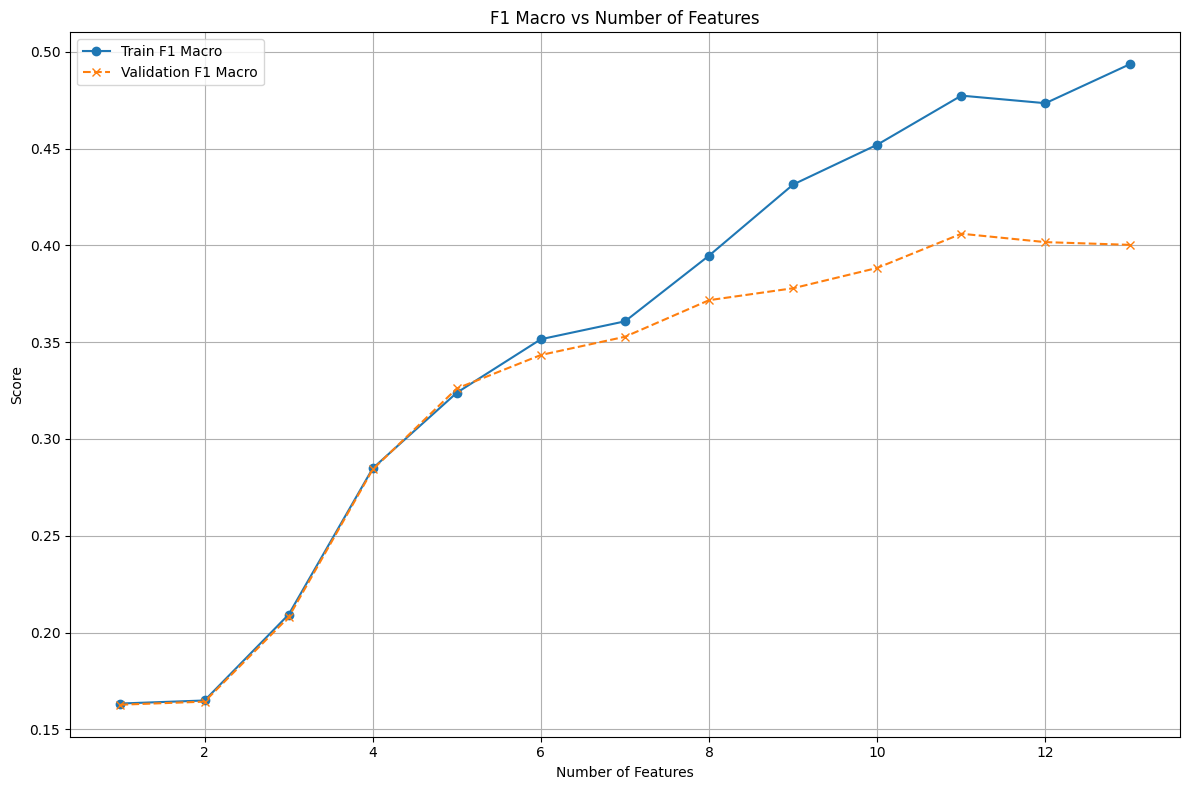

In [20]:
ranked_features = ['Attorney/Representative', 'Agreement Reached', 'C-2 Delivered',
       'Average Weekly Wage Log', 'Covid OR altr dispute', 'Industry Code',
       'Hearing Held', 'Time Assembly to Hearing', 'IME-4 Count Log',
       'Part of Body Group', 'C-3 Delivered on Time',
       'Alternative Dispute Resolution', 'Assembly Year']

# Initialize lists for storing scores
train_f1_scores = []
val_f1_scores = []

# Initialize the XGBoost model
xgb = XGBClassifier(random_state=random_state)

# Iteratively evaluate with increasing number of features
for i in range(1, len(ranked_features) + 1):
    selected_features = ranked_features[:i]
    
    # Fit the model
    xgb.fit(X_train_preprocessed_opt[selected_features], y_train_encoded)

    # Predictions for train and validation sets
    y_train_pred = xgb.predict(X_train_preprocessed_opt[selected_features])
    y_val_pred = xgb.predict(X_val_preprocessed_opt[selected_features])
    
    # Calculate F1 Macro
    f1_train = f1_score(y_train_encoded, y_train_pred, average='macro')
    f1_val = f1_score(y_val_encoded, y_val_pred, average='macro')

    # Append scores to lists
    train_f1_scores.append(f1_train)
    val_f1_scores.append(f1_val)

plt.figure(figsize=(12, 8))

# F1 Macro Plot
plt.plot(range(1, len(ranked_features) + 1), train_f1_scores, label="Train F1 Macro", linestyle='-', marker='o')
plt.plot(range(1, len(ranked_features) + 1), val_f1_scores, label="Validation F1 Macro", linestyle='--', marker='x')

plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.title("F1 Macro vs Number of Features")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [27]:
selected_features = ['Attorney/Representative', 'Agreement Reached', 'C-2 Delivered',
       'Average Weekly Wage Log', 'Covid OR altr dispute', 'Industry Code',
       'Hearing Held', 'Time Assembly to Hearing', 'IME-4 Count Log',
       'Part of Body Group', 'C-3 Delivered on Time', 'Alternative Dispute Resolution', 'Assembly Year']

# Filter datasets
X_train_preprocessed_opt = X_train_preprocessed_opt[selected_features]
X_val_preprocessed_opt = X_val_preprocessed_opt[selected_features]
test_data_preprocessed_opt = test_data_preprocessed_opt[selected_features]

**Model hyperparameter tuning:**

In [32]:
# Trying previous model on new features

weights = compute_sample_weight('balanced', y_train_encoded)

model_xgbc_tuned = XGBClassifier(
                           objective='multi:softmax',
                           n_estimators = 150,
                           max_depth = 10,
                           learning_rate = 0.01,
                           random_state = random_state
                           )

# Fit to train data
model_xgbc_tuned.fit(X_train_preprocessed_opt, y_train_encoded, sample_weight=weights)

y_pred_train = model_xgbc_tuned.predict(X_train_preprocessed_opt)
y_pred_val = model_xgbc_tuned.predict(X_val_preprocessed_opt)

print("\nClassification Report Train Data:\n", classification_report(y_train_encoded, y_pred_train, digits=6))
print("\nClassification Report Validation Data:\n", classification_report(y_val_encoded, y_pred_val, digits=6))


Classification Report Train Data:
               precision    recall  f1-score   support

           0   0.259858  0.663194  0.373405     11229
           1   0.857215  0.873867  0.865461    261970
           2   0.325165  0.156621  0.211412     62016
           3   0.851776  0.515338  0.642159    133656
           4   0.515888  0.776052  0.619774     43452
           5   0.092188  0.795251  0.165223      3790
           6   0.023921  1.000000  0.046724        87
           7   0.049794  0.997636  0.094853       423

    accuracy                       0.681752    516623
   macro avg   0.371975  0.722245  0.377376    516623
weighted avg   0.743834  0.681752  0.691913    516623


Classification Report Validation Data:
               precision    recall  f1-score   support

           0   0.262833  0.648237  0.374018      1248
           1   0.855172  0.875326  0.865132     29108
           2   0.310233  0.152685  0.204649      6890
           3   0.837943  0.505892  0.630894     14851
 

- After trying to adjust hyperparameters we concluded that the new set of features may be missing valuable variables to predict class 6, because the f1 score for that class remained zero, even after using sample weights and with previous features class 6 has predictions after sample weights were applied.
- Class 7 also has a very low score.


**SMOTE:**

In [ ]:
# Applying SMOTE

binary_var = ['Attorney/Representative', 'Agreement Reached', 'C-2 Delivered',
        'Covid OR altr dispute', 'Hearing Held', 'Time Assembly to Hearing', 
        'C-3 Delivered on Time',  'Alternative Dispute Resolution']

# Adjust the nº of observations for classes based on how hard they are to predict (f1 score for the class)
sampling_strategy = {
    2: 150000,
    5: 100000,
    6: 200000,
    7: 10000,
}

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)

# Apply SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed_opt, y_train_encoded)

model_xgbc_tuned = XGBClassifier(
                           objective='multi:softmax',
                           n_estimators = 150,
                           max_depth = 10,
                           learning_rate = 0.01,
                           random_state = random_state
                           )

# Fit to train data
model_xgbc_tuned.fit(X_train_smote, y_train_smote)

y_pred_train = model_xgbc_tuned.predict(X_train_smote)
y_pred_val = model_xgbc_tuned.predict(X_val_preprocessed_opt)

print("\nClassification Report Train Data:\n", classification_report(y_train_smote, y_pred_train, digits=6))
print("\nClassification Report Validation Data:\n", classification_report(y_val_encoded, y_pred_val, digits=6))


Classification Report Train Data:
               precision    recall  f1-score   support

           0   0.654760  0.468519  0.546200     11229
           1   0.717087  0.958991  0.820582    261970
           2   0.526125  0.202727  0.292678    150000
           3   0.691244  0.604709  0.645087    133656
           4   0.565574  0.552311  0.558864     43452
           5   0.710487  0.707730  0.709106    100000
           6   0.890487  0.998240  0.941290    200000
           7   0.786953  0.862500  0.822996     10000

    accuracy                       0.736856    910307
   macro avg   0.692840  0.669466  0.667100    910307
weighted avg   0.711964  0.736856  0.706251    910307


Classification Report Validation Data:
               precision    recall  f1-score   support

           0   0.673660  0.463141  0.548908      1248
           1   0.824687  0.958980  0.886778     29108
           2   0.312484  0.179100  0.227696      6890
           3   0.806181  0.602451  0.689583     14851
 

- After applying smote resampling strategy the score improved and all classes were predicted but in order to get this score the model overfits.
- We will apply the same resampling strategy to the datatset with the inicial pipeline preprocessing and feature selection to see if it improves f1 macro score.

In [11]:
# Applying smote to datatset preprocessed with inicial pipeline

binary_var = ['Attorney/Representative', 'C-2 Delivered',
    'Hearing Held', 'Agreement Reached', 'C-3 Delivered on Time','Part of Body Group_Trunk',
    'Part of Body Group_Lower Extremities','District Name_NYC','Part of Body Group_Upper Extremities', 
    'Gender', 'Carrier Type_2A. SIF', 'Cause of Injury Group_X', 'Cause of Injury Group_VI']

# Adjust the nº of observations for classes based on how hard they are to predict (f1 score for the class)
sampling_strategy = {
    2: 150000,
    5: 100000,
    6: 200000,
    7: 10000,
}

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)

# Apply SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train_encoded)

# Round binary variables after smote syntethic observations are added to the data set
X_train_smote[binary_var] = X_train_smote[binary_var].round()


model_xgbc_opt_2 = XGBClassifier(
                           objective='multi:softmax',
                           n_estimators = 150,
                           max_depth = 10,
                           learning_rate = 0.01,
                           random_state = random_state
                           )

# Fit to train data
model_xgbc_opt_2.fit(X_train_smote, y_train_smote)

y_pred_train = model_xgbc_opt_2.predict(X_train_preprocessed)
# Make predictions on validation data
y_pred_val = model_xgbc_opt_2.predict(X_val_preprocessed)

print("\nClassification Report Train Data:\n", classification_report(y_train_encoded, y_pred_train, digits=6))
print("\nClassification Report Validation Data:\n", classification_report(y_val_encoded, y_pred_val, digits=6))


Classification Report Train Data:
               precision    recall  f1-score   support

           0   0.699747  0.345356  0.462465     11229
           1   0.817144  0.967599  0.886030    261970
           2   0.323897  0.181356  0.232520     62016
           3   0.796683  0.621379  0.698195    133656
           4   0.660136  0.542806  0.595749     43452
           5   0.103089  0.472032  0.169221      3790
           6   0.012094  0.977011  0.023893        87
           7   0.177159  0.751773  0.286745       423

    accuracy                       0.730583    516623
   macro avg   0.448744  0.607414  0.419352    516623
weighted avg   0.730985  0.730583  0.719471    516623


Classification Report Validation Data:
               precision    recall  f1-score   support

           0   0.696574  0.342147  0.458893      1248
           1   0.815497  0.966504  0.884602     29108
           2   0.300716  0.164586  0.212738      6890
           3   0.787506  0.617130  0.691985     14851
 

- After the resampling strategy and using the initial selected features the f1 macro score impproved and the model makes predictions for all classes.
- The train and validation scores are similar.

**Final assessement and predictions:**

In [34]:
# Cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Encode the target 
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

binary_var = ['Attorney/Representative', 'C-2 Delivered',
    'Hearing Held', 'Agreement Reached', 'C-3 Delivered on Time','Part of Body Group_Trunk',
    'Part of Body Group_Lower Extremities','District Name_NYC','Part of Body Group_Upper Extremities', 
    'Gender', 'Carrier Type_2A. SIF', 'Cause of Injury Group_X', 'Cause of Injury Group_VI']

sampling_strategy = {
    2: 150000,
    5: 100000,
    6: 200000,
    7: 10000,
}

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)

# Store scores for each fold
cv_scores = []

for train_idx, val_idx in kf.split(X, y_encoded):
    
    # Data for the current split
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y_encoded[train_idx], y_encoded[val_idx]

    # Preprocess training and validation sets
    X_train_cv_preprocessed = pipeline.fit_transform(X_train_cv, y_train_cv)
    X_val_cv_preprocessed = pipeline.transform(X_val_cv)

    # Apply SMOTE
    X_train_smote_cv, y_train_smote_cv = smote.fit_resample(X_train_cv_preprocessed, y_train_cv)

    # Round binary variables after smote syntethic observations are added to the data set
    X_train_smote[binary_var] = X_train_smote[binary_var].round()

    # Fit the predefined model
    model_xgbc_opt_2.fit(X_train_smote_cv, y_train_smote_cv)

    # Predict and evaluate
    y_pred_cv = model_xgbc_opt_2.predict(X_val_cv_preprocessed)
    f1 = f1_score(y_val_cv, y_pred_cv, average='macro')

    cv_scores.append(f1)

# Convert scores to a NumPy array for easier calculations
cv_scores = np.array(cv_scores)

# Print the results
print("Cross-validation scores (F1-macro):", cv_scores)
print("Mean CV score:", cv_scores.mean())

Cross-validation scores (F1-macro): [0.40024773 0.40698883 0.40076974 0.40426626 0.39658768]
Mean CV score: 0.4017720470503418


- The f1 macro score is consistent across folds and reached 0.4018 f1 macro on average.

**Predictions for test using all train dataset:**

In [24]:
binary_var_X = ['Attorney/Representative', 'Agreement Reached', 'C-2 Delivered','Covid OR altr dispute','Hearing Held', 'C-3 Delivered on Time', 'Alternative Dispute Resolution']

# Encode target
y_encoded = label_encoder.fit_transform(y)

# Fit pipeline on X and apply tranformations
X_preprocessed = pipeline.fit_transform(X, y_encoded)

# Apply pipeline fitted on X
test_data_preprocessed_X = pipeline.transform(test_transformed_agreement)

# Apply SMOTE
X_smote, y_smote = smote.fit_resample(X_preprocessed, y_encoded)

# Round binary variables after smote syntethic observations are added to the data set
X_smote[binary_var_X] = X_smote[binary_var_X].round()

# Fit on X 
model_xgbc_opt_2.fit(X_smote,y_smote)

# Make predictions on test data
y_pred = model_xgbc_opt_2.predict(test_data_preprocessed_X)

# Get original y for submission
y_pred_categorical = label_encoder.inverse_transform(y_pred) 

submission = pd.DataFrame({
    "Claim Identifier": test_data_preprocessed_X.index,
    "Claim Injury Type": y_pred_categorical
})

# Save to CSV to upload on kaggle
submission.to_csv("Group46_versionX.csv", index=False)

Kaggle score on test: 0.36978